<a href="https://colab.research.google.com/github/alfinmaulani/skripsi2/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch

if torch.cuda.is_available():
  # device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

No GPU available, using the CPU instead


In [65]:
korpusgabung='/content/drive/MyDrive/fake news/beritapalsugabung.csv'
df=pd.read_csv(korpusgabung)
# df.columns=['teks']

In [70]:
df

,text,label
12,Republicans have had seven years to come up wi...,0
15,Donald Trump just signed the GOP tax scam into...,0
16,A new animatronic figure in the Hall of Presid...,0
17,Trump supporters and the so-called president s...,0
28,Donald Trump held a rally for Alabama Senate c...,0
...,...,...
44883,ON BOARD A U.S. MILITARY AIRCRAFT (Reuters) - ...,1
44889,GENEVA (Reuters) - North Korea and the United ...,1
44890,GENEVA (Reuters) - North Korea and the United ...,1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1


In [73]:
df.shape

(11224, 2)

In [68]:
df = df.drop(df[df.label == 1].sample(frac=0.75).index)
df = df.drop(df[df.label == 0].sample(frac=0.75).index)

In [74]:
df

,text,label
12,Republicans have had seven years to come up wi...,0
15,Donald Trump just signed the GOP tax scam into...,0
16,A new animatronic figure in the Hall of Presid...,0
17,Trump supporters and the so-called president s...,0
28,Donald Trump held a rally for Alabama Senate c...,0
...,...,...
44883,ON BOARD A U.S. MILITARY AIRCRAFT (Reuters) - ...,1
44889,GENEVA (Reuters) - North Korea and the United ...,1
44890,GENEVA (Reuters) - North Korea and the United ...,1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1


In [75]:
df.shape

(11224, 2)

In [76]:
df.label.value_counts().index

Int64Index([0, 1], dtype='int64')

In [77]:
df.label.value_counts()

0    5870
1    5354
Name: label, dtype: int64

Text(0, 0.5, 'samples')

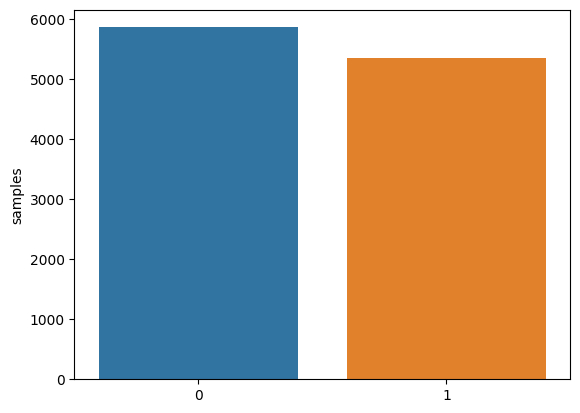

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

x=df.label.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')

In [79]:
sentences = df.text.values
labels = df.label.values  

load bert tokenizer

In [80]:
from transformers import BertTokenizer

print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer


In [81]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  Republicans have had seven years to come up with a viable replacement for Obamacare but they failed miserably. After taking a victory lap for gifting the wealthy with a tax break on Wednesday, Donald Trump looked at the cameras and said,  We have essentially repealed Obamacare and we will come up with something that will be much better. Obamacare has been repealed in this bill,  he added. Well, like most things Trump says, that s just not true. But, if the former reality show star could have done that in order to eradicate former President Obama s signature legislation, he would have and without offering an alternative.Senate Majority Leader Mitch McConnell told NPR that  This has not been a very bipartisan year. I hope in the new year, we re going to pivot here and become more cooperative. An Obamacare repeal in 2018 is DOA. Well, we obviously were unable to completely repeal and replace with a 52-48 Senate,  the Kentucky Republican said.  We ll have to take a look at what 

In [82]:
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(sent, add_special_tokens = True, max_length=14285, truncation=True)
  # encoded_sent = tokenizer.encode(sent, add_special_tokens = True, max_length: Optional[int]=None)
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])



Original:  Republicans have had seven years to come up with a viable replacement for Obamacare but they failed miserably. After taking a victory lap for gifting the wealthy with a tax break on Wednesday, Donald Trump looked at the cameras and said,  We have essentially repealed Obamacare and we will come up with something that will be much better. Obamacare has been repealed in this bill,  he added. Well, like most things Trump says, that s just not true. But, if the former reality show star could have done that in order to eradicate former President Obama s signature legislation, he would have and without offering an alternative.Senate Majority Leader Mitch McConnell told NPR that  This has not been a very bipartisan year. I hope in the new year, we re going to pivot here and become more cooperative. An Obamacare repeal in 2018 is DOA. Well, we obviously were unable to completely repeal and replace with a 52-48 Senate,  the Kentucky Republican said.  We ll have to take a look at what 

In [83]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  10292


In [84]:
from keras.utils import pad_sequences

In [85]:
from keras.utils import pad_sequences

MAX_LEN = 14290

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 14290 values
Padding token: "[PAD]", ID: 0
Done


In [86]:
input_ids[0]

array([  101, 10643,  2031, ...,     0,     0,     0])

In [87]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

persiapan data

In [88]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2017,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2017,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=2018,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=2018,
                                                     test_size=0.15)

In [89]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (8585, 14290)
Label:  (8585,)
Mask:  (8585, 14290)

== Validation ==
Input:  (1516, 14290)
Label:  (1516,)
Mask:  (1516, 14290)

== Test ==
Input:  (1123, 14290)
Label:  (1123,)
Mask:  (1123, 14290)


In [90]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [91]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)